## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [ ]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [ ]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-19 15:37:05--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-19 15:37:06--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [ ]:
CUDA_DEVICE_ID = 0  # change if needed

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.58MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 41.3MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.30MB/s]


Text(0.5, 1.0, 'Image label: 8')

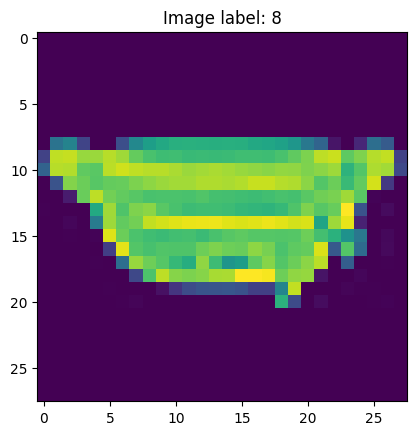

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [ ]:
# Creating model instance
model_task_1 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(64 * 7 * 7, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

Не забудьте перенести модель на выбранный `device`!

In [ ]:
model_task_1.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.AdamW(model_task_1.parameters(), lr=learning_rate)

for epoch in range(8):
    model_task_1.train()
    loss_function = torch.nn.CrossEntropyLoss()
    for batch in train_data_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        y_predicted = model_task_1(x)
        loss = loss_function(y_predicted, y)
        loss.backward()
        optimizer.step()
        # print(f"Epoch: {epoch}, Loss: {loss.item()}")
    print(f'Epoch: {epoch}, Loss: {get_accuracy(model_task_1, train_data_loader)}')

Epoch: 0, Loss: 0.9182999730110168
Epoch: 1, Loss: 0.9358166456222534
Epoch: 2, Loss: 0.9454500079154968
Epoch: 3, Loss: 0.956083357334137
Epoch: 4, Loss: 0.9580833315849304
Epoch: 5, Loss: 0.9577500224113464
Epoch: 6, Loss: 0.9730666875839233
Epoch: 7, Loss: 0.9764000177383423


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.9764


In [ ]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9187


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [ ]:
# Creating model instance
# I want to use Small ResNet, with skip-connections
# but without batchNorm

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
        )

        # skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True)
            )
    def forward(self, x):
        return nn.functional.relu(self.main_path(x)+self.shortcut(x))

class ResNet_overfit(nn.Module):
    def __init__(self):
        super(ResNet_overfit, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True)
        )

        # Res-blocks
        self.res_block1 = ResidualBlock(64, 64)
        self.res_block2 = ResidualBlock(64, 128, stride=2)
        self.res_block3 = ResidualBlock(128, 256, stride=2)

        # classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        x = self.initial(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.classifier(x)
        return x

model_task_2 = ResNet_overfit()

In [ ]:
# Move model to device
model_task_2.to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model_task_2.parameters(), lr=learning_rate, weight_decay=0.0)
loss_function = torch.nn.CrossEntropyLoss()


num_epochs = 20
for epoch in range(num_epochs):
    model_task_2.train()
    running_loss = 0.0

    for batch_idx, (x, y) in enumerate(train_data_loader):
        x, y = x.to(device), y.to(device)

        # Forward pass
        optimizer.zero_grad()
        y_predicted = model_task_2(x)
        loss = loss_function(y_predicted, y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}, Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    # Check training and test accuracy after each epoch
    train_acc = get_accuracy(model_task_2, train_data_loader)
    test_acc = get_accuracy(model_task_2, test_data_loader)
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Accuracy: {train_acc:.4f}')
    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  Gap: {train_acc - test_acc:.4f}')

    # Early stopping if we've achieved sufficient overfitting
    if train_acc >= 0.99:
        break

# Final evaluation
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"\nFinal Results:")
print(f"Neural network accuracy on train set: {train_acc_task_2:.4f}")
print(f"Neural network accuracy on test set: {test_acc_task_2:.4f}")
print(f"Accuracy gap (overfitting measure): {train_acc_task_2 - test_acc_task_2:.4f}")

Epoch: 1/20, Batch: 100, Loss: 0.3088
Epoch: 1/20, Batch: 200, Loss: 0.2986
Epoch: 1/20, Batch: 300, Loss: 0.2920
Epoch: 1/20, Batch: 400, Loss: 0.2778
Epoch: 1/20, Batch: 500, Loss: 0.2989
Epoch: 1/20, Batch: 600, Loss: 0.2927
Epoch: 1/20, Batch: 700, Loss: 0.2721
Epoch: 1/20, Batch: 800, Loss: 0.2845
Epoch: 1/20, Batch: 900, Loss: 0.2807
Epoch: 1/20, Batch: 1000, Loss: 0.2811
Epoch: 1/20, Batch: 1100, Loss: 0.3075
Epoch: 1/20, Batch: 1200, Loss: 0.2818
Epoch: 1/20, Batch: 1300, Loss: 0.2629
Epoch: 1/20, Batch: 1400, Loss: 0.2710
Epoch: 1/20, Batch: 1500, Loss: 0.2681
Epoch: 1/20, Batch: 1600, Loss: 0.2782
Epoch: 1/20, Batch: 1700, Loss: 0.2634
Epoch: 1/20, Batch: 1800, Loss: 0.2700
Epoch 1/20:
  Train Accuracy: 0.9102
  Test Accuracy: 0.8967
  Gap: 0.0135
Epoch: 2/20, Batch: 100, Loss: 0.2440
Epoch: 2/20, Batch: 200, Loss: 0.2473
Epoch: 2/20, Batch: 300, Loss: 0.2296
Epoch: 2/20, Batch: 400, Loss: 0.2281
Epoch: 2/20, Batch: 500, Loss: 0.2490
Epoch: 2/20, Batch: 600, Loss: 0.2066
Epoc

Проверка архитектуры:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [ ]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.99282


In [ ]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.9231


Проверка, что переобучение присутствует:

In [ ]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [ ]:
# Improve previous model
# add: BatchNorm, Dropout, weight decay

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return nn.functional.relu(self.main_path(x) + self.shortcut(x))

class ResNet_stable(nn.Module):
    def __init__(self):
        super(ResNet_stable, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Res-blocks
        self.res_block1 = ResidualBlock(64, 64)
        self.res_block2 = ResidualBlock(64, 128, stride=2)
        self.res_block3 = ResidualBlock(128, 256, stride=2)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        # classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.res_block1(x)
        x = self.dropout1(x)
        x = self.res_block2(x)
        x = self.dropout2(x)
        x = self.res_block3(x)
        x = self.dropout3(x)
        x = self.classifier(x)
        return x

model_task_3 = ResNet_stable()
model_task_3.to(device)

ResNet_stable(
  (initial): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res_block1): ResidualBlock(
    (main_path): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential()
  )
  (res_block2): ResidualBlock(
    (main_path): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplac

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model_task_3.parameters(), lr=learning_rate, weight_decay=1e-4)
loss_function = torch.nn.CrossEntropyLoss()

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    torchvision.transforms.ToTensor()
])

train_fmnist_data_aug = FashionMNIST(
    ".", train=True, transform=transform_train, download=False
)

train_data_loader_aug = torch.utils.data.DataLoader(
    train_fmnist_data_aug, batch_size=32, shuffle=True, num_workers=2
)

num_epochs = 15
best_test_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model_task_3.train()
    running_loss = 0.0

    for batch_idx, (x, y) in enumerate(train_data_loader_aug):
        x, y = x.to(device), y.to(device)

        # Forward pass
        optimizer.zero_grad()
        y_predicted = model_task_3(x)
        loss = loss_function(y_predicted, y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}, Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    # Check training and test accuracy after each epoch
    train_acc = get_accuracy(model_task_3, train_data_loader)  # Evaluate on non-augmented data
    test_acc = get_accuracy(model_task_3, test_data_loader)
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Accuracy: {train_acc:.4f}')
    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  Gap: {train_acc - test_acc:.4f}')

    # Early stopping based on test accuracy and gap
    if test_acc > best_test_acc and (train_acc - test_acc) <= 0.015:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save(model_task_3.state_dict(), 'best_model_task_3.pth')
        print(f"New best model saved with test accuracy: {test_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Load the best model
if os.path.exists('best_model_task_3.pth'):
    model_task_3.load_state_dict(torch.load('best_model_task_3.pth'))
    print("Loaded the best model")

train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"\nFinal Results:")
print(f"Neural network accuracy on train set: {train_acc_task_3:.4f}")
print(f"Neural network accuracy on test set: {test_acc_task_3:.4f}")
print(f"Accuracy gap: {train_acc_task_3 - test_acc_task_3:.4f}")

Epoch: 1/15, Batch: 100, Loss: 1.3291
Epoch: 1/15, Batch: 200, Loss: 0.9149
Epoch: 1/15, Batch: 300, Loss: 0.8282
Epoch: 1/15, Batch: 400, Loss: 0.7242
Epoch: 1/15, Batch: 500, Loss: 0.6604
Epoch: 1/15, Batch: 600, Loss: 0.6365
Epoch: 1/15, Batch: 700, Loss: 0.6091
Epoch: 1/15, Batch: 800, Loss: 0.6385
Epoch: 1/15, Batch: 900, Loss: 0.6074
Epoch: 1/15, Batch: 1000, Loss: 0.5924
Epoch: 1/15, Batch: 1100, Loss: 0.5801
Epoch: 1/15, Batch: 1200, Loss: 0.5525
Epoch: 1/15, Batch: 1300, Loss: 0.5174
Epoch: 1/15, Batch: 1400, Loss: 0.5475
Epoch: 1/15, Batch: 1500, Loss: 0.4954
Epoch: 1/15, Batch: 1600, Loss: 0.5336
Epoch: 1/15, Batch: 1700, Loss: 0.5199
Epoch: 1/15, Batch: 1800, Loss: 0.5022
Epoch 1/15:
  Train Accuracy: 0.8230
  Test Accuracy: 0.8168
  Gap: 0.0062
New best model saved with test accuracy: 0.8168
Epoch: 2/15, Batch: 100, Loss: 0.4881
Epoch: 2/15, Batch: 200, Loss: 0.4751
Epoch: 2/15, Batch: 300, Loss: 0.4766
Epoch: 2/15, Batch: 400, Loss: 0.4567
Epoch: 2/15, Batch: 500, Loss: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792aa017ede0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x792aa017ede0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():^^
 ^ ^ ^  ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^ ^ 
  File "/usr/lib/pyth

Epoch 8/15:
  Train Accuracy: 0.9149
  Test Accuracy: 0.9050
  Gap: 0.0099
New best model saved with test accuracy: 0.9050
Epoch: 9/15, Batch: 100, Loss: 0.3107
Epoch: 9/15, Batch: 200, Loss: 0.3250
Epoch: 9/15, Batch: 300, Loss: 0.3159
Epoch: 9/15, Batch: 400, Loss: 0.3109
Epoch: 9/15, Batch: 500, Loss: 0.3054
Epoch: 9/15, Batch: 600, Loss: 0.3193
Epoch: 9/15, Batch: 700, Loss: 0.3028
Epoch: 9/15, Batch: 800, Loss: 0.2912
Epoch: 9/15, Batch: 900, Loss: 0.3055
Epoch: 9/15, Batch: 1000, Loss: 0.3220
Epoch: 9/15, Batch: 1100, Loss: 0.3096
Epoch: 9/15, Batch: 1200, Loss: 0.3081
Epoch: 9/15, Batch: 1300, Loss: 0.2927
Epoch: 9/15, Batch: 1400, Loss: 0.3005
Epoch: 9/15, Batch: 1500, Loss: 0.3229
Epoch: 9/15, Batch: 1600, Loss: 0.2973
Epoch: 9/15, Batch: 1700, Loss: 0.2906
Epoch: 9/15, Batch: 1800, Loss: 0.3179
Epoch 9/15:
  Train Accuracy: 0.9165
  Test Accuracy: 0.9050
  Gap: 0.0115
Epoch: 10/15, Batch: 100, Loss: 0.2889
Epoch: 10/15, Batch: 200, Loss: 0.2984
Epoch: 10/15, Batch: 300, Loss:

Проверка архитектуры:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [ ]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.92653


In [ ]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.9176


Проверка, что переобучение присутствует:

In [ ]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!